# 实战Kaggle比赛：预测房价
---


实现几个函数方便下载数据

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('.','data')):
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name}不存在于{DATA_HUB}."
    url, shal_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        shal = hashlib.shal()
        with open(fname, 'rb') as f:
            while True:
                data = f.requestsad(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

实现两个实用函数： 一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [2]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

使用pandas读入并处理数据

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd 
import torch
from torch import nn
from d2l import torch as d2l 

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载.\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载.\data\kaggle_house_pred_test.csv...
(1460, 81)
(1459, 80)


前四个和最后两个特征，以及相应的标签（房价）

In [4]:
print(train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]]) #iloc[]是pandas的索引函数

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


在每个样本中，第一个特征是ID，我们将其从数据集中删除

In [5]:
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))

将所有缺失的值替换为相应特征的平均值。通过将特征重新缩放到零均值和单位方差来标准化数据

In [6]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
 lambda x: (x - x.mean() / (x.std())))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理离散值。我们用一次独热编码替换他们

In [7]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [8]:
print(all_features.iloc[0:4, [0,1,2,3,-3,-2,-1]])

   MSSubClass  LotFrontage       LotArea  OverallQual  SaleCondition_Normal  \
0    58.65614    62.031224   8448.710775     2.681348                     1   
1    18.65614    77.031224   9598.710775     1.681348                     1   
2    58.65614    65.031224  11248.710775     2.681348                     1   
3    68.65614    57.031224   9548.710775     2.681348                     0   

   SaleCondition_Partial  SaleCondition_nan  
0                      0                  0  
1                      0                  0  
2                      0                  0  
3                      0                  0  


从pandas格式中提取Numpy格式，并将其转换为张量表示

In [16]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)


训练

In [17]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

![title](./picture/15相对误差.png)

In [18]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

我们的训练函数将借助Adam优化器 （我们将在后面章节更详细地描述它）。 Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

In [19]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K折交叉验证<br>
我们首先需要定义一个函数，在K折交叉验证过程中返回第i折的数据。 具体地说，它选择第i个切片作为验证数据，其余部分作为训练数据。 注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。

In [20]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。

In [21]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.158792, 验证log rmse0.154618
折2，训练log rmse0.170686, 验证log rmse0.184017
折3，训练log rmse0.181218, 验证log rmse0.186856
折4，训练log rmse0.164291, 验证log rmse0.160353
折5，训练log rmse0.157069, 验证log rmse0.188253
5-折验证: 平均训练log rmse: 0.166411, 平均验证log rmse: 0.174819


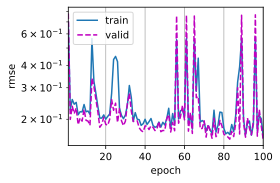

In [29]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 3, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## lr = 3

![title](./picture/15lr=3.png)

## lr = 0.1

![title](./picture/15lr=01.png)

## lr = 0.01

![title](./picture/15lr=001.png)

## lr = 0.001

![title](./picture/15lr=0001.png)